**Table of contents**<a id='toc0_'></a>    
- [Titanic survivor prediction](#toc1_)    
  - [Loading the dataset](#toc1_1_)    
  - [Data exploration](#toc1_2_)    
    - [Null values](#toc1_2_1_)    
    - [How each column correlates with survivability](#toc1_2_2_)    
  - [Data preprocessing](#toc1_3_)    
    - [Age groups](#toc1_3_1_)    
    - [One Hot Encoding](#toc1_3_2_)    
    - [Final adjust](#toc1_3_3_)    
    - [Correlations with output](#toc1_3_4_)    
    - [Final function](#toc1_3_5_)    
  - [Model](#toc1_4_)    
  - [Test data](#toc1_5_)    
    - [Output for submission](#toc1_5_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Titanic survivor prediction](#toc0_)
This notebook contains my solution to the most famous problem on Kaggle: predicting which passengers survived the titanic disaster. It contains the entire process of data treatment, validation, feature extraction, model training and output.

Challenge page: https://www.kaggle.com/competitions/titanic

It implements a random forest model on the data. The final test score was 0.78748

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# random state used in all notebook
rstate = 7

## <a id='toc1_1_'></a>[Loading the dataset](#toc0_)

In [2]:
raw_titanic_data = pd.read_csv('data/titanic/train.csv', index_col='PassengerId')
raw_titanic_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# we are going to use the raw data later
titanic_data = raw_titanic_data.copy()

In [4]:
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


## <a id='toc1_2_'></a>[Data exploration](#toc0_)

First, let's see if the data is valid and look at it. Since thete are only 11 columns, we can check them individually

In [5]:
def plot_counts(df, column):
    """Plot the value counts for a column in a dataframe
    """
    df[column].value_counts().plot(kind='bar')
    plt.xlabel(column)
    plt.ylabel('Count')

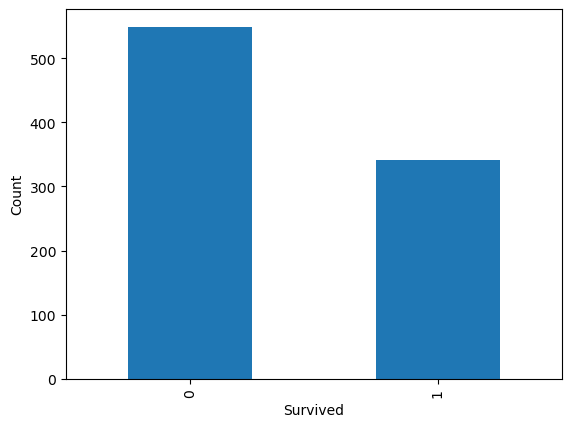

In [6]:
plot_counts(titanic_data, 'Survived')

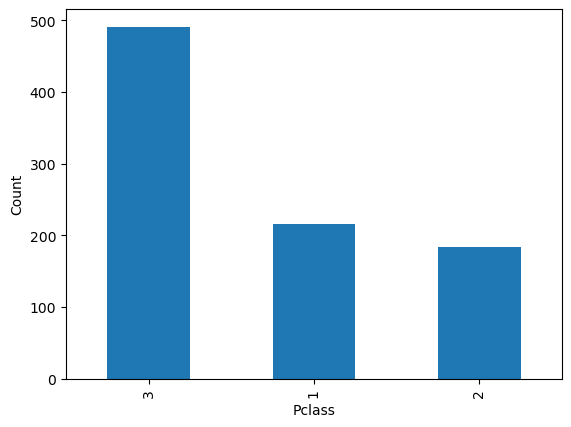

In [7]:
plot_counts(titanic_data, 'Pclass')

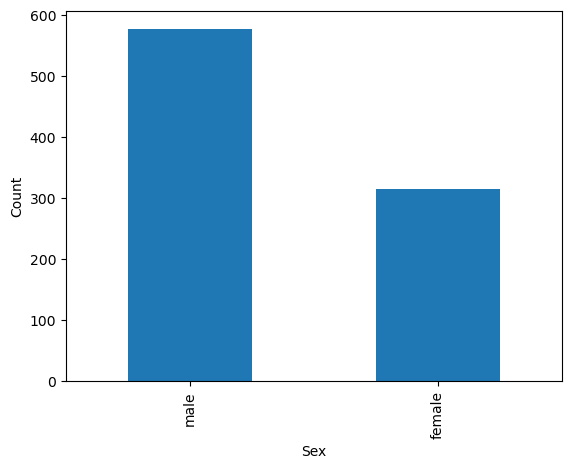

In [8]:
plot_counts(titanic_data, 'Sex')

In [9]:
titanic_data[['Age', 'SibSp', 'Parch', 'Fare']].describe()

,Age,SibSp,Parch,Fare
count,714.000000,891.000000,891.000000,891.000000
mean,29.699118,0.523008,0.381594,32.204208
std,14.526497,1.102743,0.806057,49.693429
min,0.420000,0.000000,0.000000,0.000000
25%,20.125000,0.000000,0.000000,7.910400
50%,28.000000,0.000000,0.000000,14.454200
75%,38.000000,1.000000,0.000000,31.000000
max,80.000000,8.000000,6.000000,512.329200


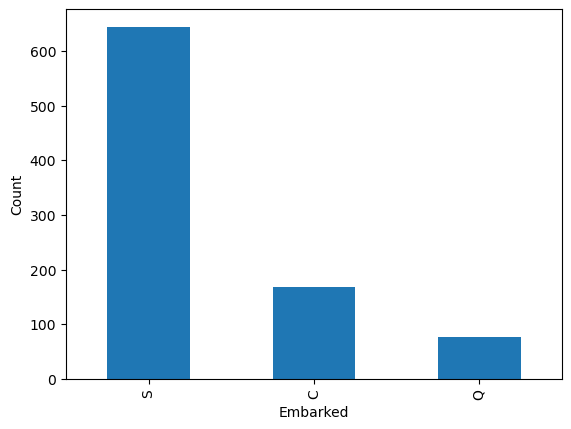

In [10]:
plot_counts(titanic_data, 'Embarked')

The values are all valid. We are going to check the null values

### <a id='toc1_2_1_'></a>[Null values](#toc0_)

In [11]:
titanic_data.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

The null values are in Age, Cabin and Embarked. Let's check

In [12]:
titanic_data[titanic_data['Age'].isna()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...
860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S


In [13]:
titanic_data[titanic_data['Embarked'].isna()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [14]:
titanic_data[~titanic_data['Cabin'].isna()].head(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S
22,1,2,"Beesley, Mr. Lawrence",male,34.0,0,0,248698,13.0000,D56,S
24,1,1,"Sloper, Mr. William Thompson",male,28.0,0,0,113788,35.5000,A6,S
28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0000,C23 C25 C27,S
32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,B78,C


Cabin has so many null values, and at first seems to have no relation with the other info. We are going to ignore this column.

Age is a important column with many null values. We will try different imputations for this one. At first, we are going to impute the mean age.

Embarked has only two missing values, so let's just fill these with the mode

In [15]:
# marking the missing ages. Maybe the age is missing because of something
titanic_data['AgeMissing'] = False
titanic_data.loc[titanic_data['Age'].isna(), 'AgeMissing'] = True

# filling the embarked with mode
emb_mode = titanic_data['Embarked'].mode()[0]
titanic_data['Embarked'] = titanic_data['Embarked'].fillna(emb_mode)

# filling the age with mean
age_mean = titanic_data['Age'].mean()
titanic_data['Age'] = titanic_data['Age'].fillna(age_mean)

# cabin drop
titanic_data = titanic_data.drop(columns=['Cabin'])

### <a id='toc1_2_2_'></a>[How each column correlates with survivability](#toc0_)

In [16]:
def plot_survived_by_column(titanic_data, column):
    """Plot how many survived on side of the total for a categorical column
    """
    
    group = titanic_data.groupby(column)
    ind = np.arange(len(group))
    width = 0.35

    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.bar(ind, group['Survived'].count(), width, label='Total')
    ax.bar(ind+width, group['Survived'].sum(), width, label='Survived')

    

    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(group['Survived'].count().index)
    ax.legend()
    ax.set_ylabel('Count')
    ax.set_xlabel(column)

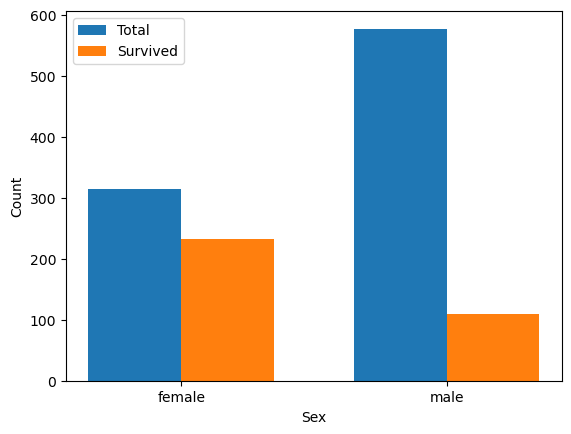

In [17]:
plot_survived_by_column(titanic_data, 'Sex')

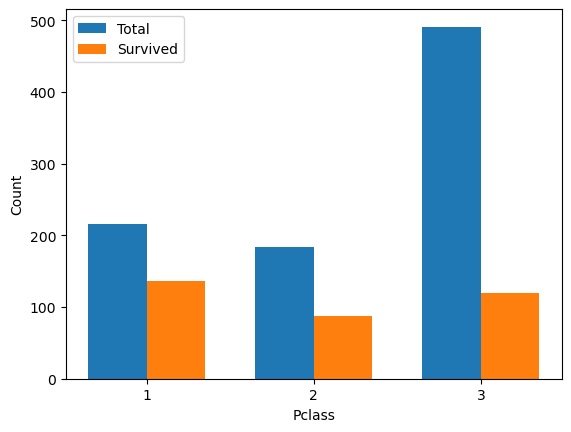

In [18]:
plot_survived_by_column(titanic_data, 'Pclass')

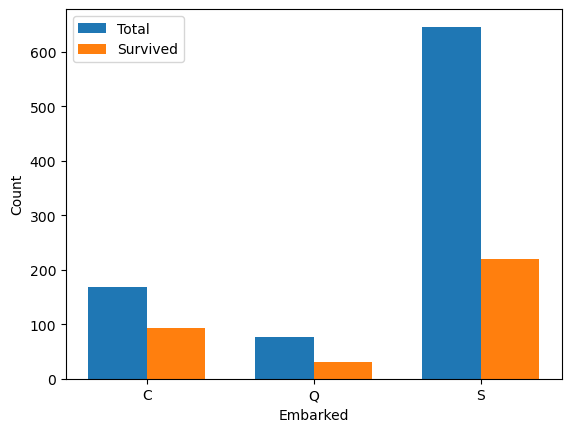

In [19]:
plot_survived_by_column(titanic_data, 'Embarked')

In [20]:
def percentages_of_survivability(titanic_data, column):
    """Return the percentage of survivability for each value in a column
    """
    survival = titanic_data.groupby(column)['Survived'].agg(['count', 'sum'])
    survival = survival.rename(columns={'sum': 'Survived', 'count': 'Total'})
    survival['Survivability [%]'] = survival['Survived'] / survival['Total'] * 100
    return survival

In [21]:
# since this one is not so clear by the graph, lets calculate the percentage
# of survivability for each
percentages_of_survivability(titanic_data, 'Embarked')

,Total,Survived,Survivability [%]
Embarked,,,
C,168,93,55.357143
Q,77,30,38.961039
S,646,219,33.900929


What we can see
- Sex: Female has a lot more chance of survival. Makes sense because the rule for the life boats give a preference for them
- Pclass: the higher the class of the ticket, higher the chance of survival, as expected, because richer people are in the higher cabins.
- Embarked: Seems to make a difference, but it's not clear why. Maybe a correlation for the port with other data.

Text(0, 0.5, 'Fare')

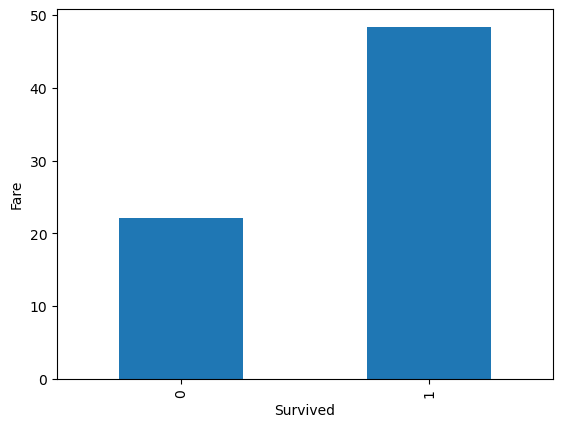

In [22]:
titanic_data.groupby('Survived').Fare.mean().plot(kind='bar')
plt.ylabel('Fare')

The passengers with higher fare had a grater chance of surviving

In [23]:
percentages_of_survivability(titanic_data, 'SibSp')

,Total,Survived,Survivability [%]
SibSp,,,
0,608,210,34.539474
1,209,112,53.588517
2,28,13,46.428571
3,16,4,25.000000
4,18,3,16.666667
5,5,0,0.000000
8,7,0,0.000000


In [24]:
percentages_of_survivability(titanic_data, 'Parch')

,Total,Survived,Survivability [%]
Parch,,,
0,678,233,34.365782
1,118,65,55.084746
2,80,40,50.000000
3,5,3,60.000000
4,4,0,0.000000
5,5,1,20.000000
6,1,0,0.000000


In [25]:
percentages_of_survivability(titanic_data, 'AgeMissing')

,Total,Survived,Survivability [%]
AgeMissing,,,
False,714,290,40.616246
True,177,52,29.378531


We can see that having a sibling, spouse or parent seems to increase the chance of surviving. If the quantity matters, it's hard to know since for values higher than two we have only few samples, but seems that having a greater number seems to reduce the chance. For the SibSp for example, where it is higher than 3 the survivability goes very low.

We also can see that people that are missing age on the dataset survive less. Probably because it was harder to find the age for the non-survivals

## <a id='toc1_3_'></a>[Data preprocessing](#toc0_)

Now let's process our data to a state where we can use a model on it

### <a id='toc1_3_1_'></a>[Age groups](#toc0_)

We will do some feature engenerring on the age column, to group people into age classes, since the young had preference to go on the life boats.

In [26]:
def create_age_group(titanic_data, minage, maxage, name, enc):
    titanic_data.loc[(titanic_data['Age'] >= minage) & (titanic_data['Age'] < maxage), 'AgeGroup'] = name
    titanic_data.loc[(titanic_data['Age'] >= minage) & (titanic_data['Age'] < maxage), 'AgeGroupEn'] = enc

    
def groups_of_age(titanic_data):
    """Create groups based on the age, from Child to Elder.
    Generates a categorical column and a encoded column"""
    
    titanic_data['AgeGroup'] = None
    titanic_data['AgeGroupEn'] = 0
    
    groups = [
        [0, 9, 'Child', 0],
        [9, 18, 'Teen', 1],
        [18, 30, 'Young', 2],
        [30, 60, 'Adult', 3],
        [60, 81, 'Elder', 4]
    ]

    for minage, maxage, name, enc in groups:
        create_age_group(titanic_data, minage, maxage, name, enc)
        
    return titanic_data


In [27]:
titanic_data = groups_of_age(titanic_data)

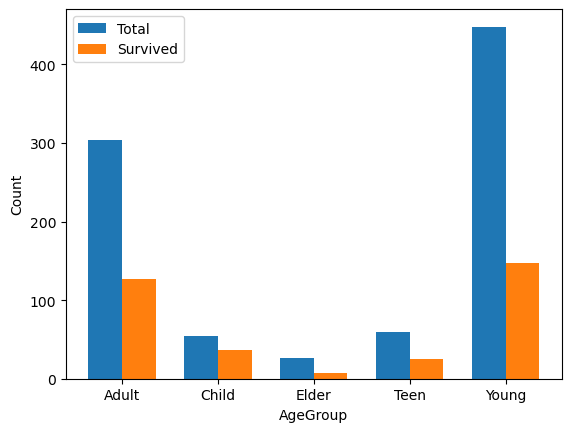

In [28]:
plot_survived_by_column(titanic_data, 'AgeGroup')

In [29]:
print('Percentages of survivability')
embarked_survival = titanic_data.groupby('AgeGroup')['Survived'].agg(['count', 'sum'])
(embarked_survival['sum'] / embarked_survival['count'] * 100).sort_values(ascending=False)

Percentages of survivability


AgeGroup
Child    66.666667
Teen     42.372881
Adult    41.776316
Young    32.812500
Elder    26.923077
dtype: float64

As expected, the child has the greater survivability, since they had preference to go on the life boats. The elder had the smaller chance of survival, probably because the lack of preferrence and difficulties to get to the life boats.

### <a id='toc1_3_2_'></a>[One Hot Encoding](#toc0_)
One hot encoding the categorical columns to put in the model

In [30]:
titanic_data = pd.get_dummies(titanic_data, columns=['Sex', 'Embarked'], drop_first=True)

### <a id='toc1_3_3_'></a>[Final adjust](#toc0_)
Let's do a final adjustement to our data by dropping the unecessary columns

In [31]:
titanic_data.drop(columns=['Name', 'Ticket', 'AgeGroup'])

,Survived,Pclass,Age,SibSp,Parch,Fare,AgeMissing,AgeGroupEn,Sex_male,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,
1,0,3,22.000000,1,0,7.2500,False,2,1,0,1
2,1,1,38.000000,1,0,71.2833,False,3,0,0,0
3,1,3,26.000000,0,0,7.9250,False,2,0,0,1
4,1,1,35.000000,1,0,53.1000,False,3,0,0,1
5,0,3,35.000000,0,0,8.0500,False,3,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,27.000000,0,0,13.0000,False,2,1,0,1
888,1,1,19.000000,0,0,30.0000,False,2,0,0,1
889,0,3,29.699118,1,2,23.4500,True,2,0,0,1


### <a id='toc1_3_4_'></a>[Correlations with output](#toc0_)
Out target is a binary variable. To correlate with it, we are going to use:

- point biserial correlation for continuous variables
- Matthews correlation cofficient for boolean variables

Both range from -1 to 1 , with negative values indicating negative correlation (higher the value of the variable, less chance of surviving) and positive values indicating positive correlation (higher the value of the variable, more chance of surviving)

In [32]:
titanic_data.dtypes

Survived        int64
Pclass          int64
Name           object
Age           float64
SibSp           int64
Parch           int64
Ticket         object
Fare          float64
AgeMissing       bool
AgeGroup       object
AgeGroupEn      int64
Sex_male        uint8
Embarked_Q      uint8
Embarked_S      uint8
dtype: object

Text(0.5, 0, 'Correlation')

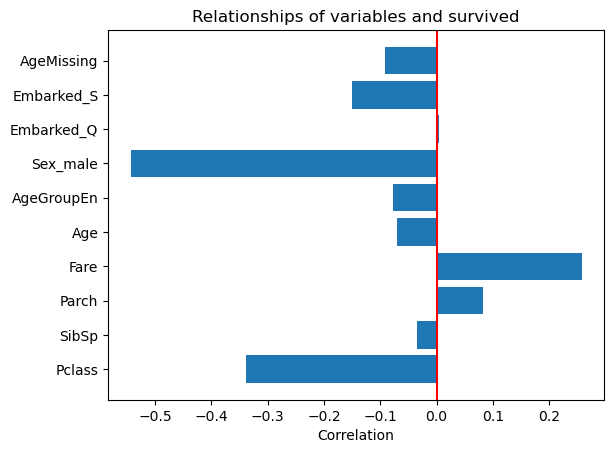

In [33]:
from scipy.stats import pointbiserialr
from sklearn.metrics import matthews_corrcoef

cols_continuous = ["Pclass", "SibSp", "Parch", "Fare", "Age", "AgeGroupEn"]
corr = []
for col in cols_continuous:
    corr.append(pointbiserialr(titanic_data['Survived'], titanic_data[col]).statistic)
    
cols_bool = ['Sex_male', 'Embarked_Q', 'Embarked_S', "AgeMissing"]
for col in cols_bool:
    corr.append(matthews_corrcoef(titanic_data['Survived'], titanic_data[col]))
    
plt.barh(cols_continuous + cols_bool, corr)
plt.axvline(0, color='red')
plt.title("Relationships of variables and survived")
plt.xlabel("Correlation")

The negative values indicate less chance of surviving. 

It makes sense, for example, that Sex_male has a strong negative since man had less chance of surviving. 

A higher Fare indicates a better financial condition and better chance of surviving because of it.

A higher Pclass (that means lower financial value, 3 is the lowest and 1 the highest), means less chance of surviving

Text(0.5, 0, 'Correlation')

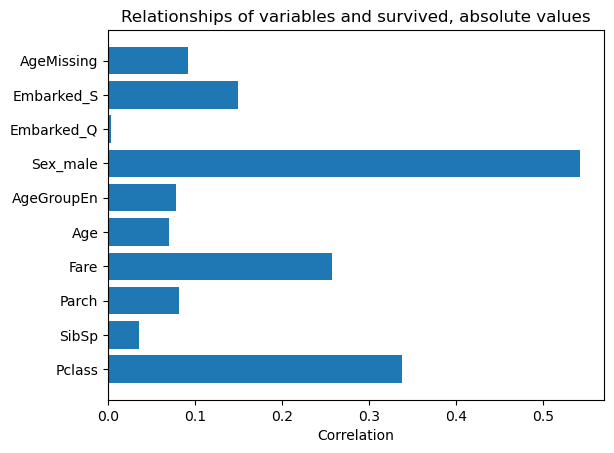

In [34]:
plt.barh(cols_continuous + cols_bool, [abs(c) for c in corr])
plt.axvline(0, color='red')
plt.title("Relationships of variables and survived, absolute values")
plt.xlabel("Correlation")

Here we can see the correlations. Sex have a very strong correlation, Pclass too.

Age group encoded has a little more than age, so we are going to maintain the groups and drop the Age

### <a id='toc1_3_5_'></a>[Final function](#toc0_)
Build a function that does all the treatment nedded


In [35]:
def data_process(raw_titanic_data):
    """Process the raw titanic data and get it ready to modelling
    """
    
    titanic_data = raw_titanic_data.copy()
    
    # marking the missing ages.
    titanic_data['AgeMissing'] = False
    titanic_data.loc[titanic_data['Age'].isna(), 'AgeMissing'] = True
    
    # filling the embarked with mode
    emb_mode = titanic_data['Embarked'].mode()[0]
    titanic_data['Embarked'] = titanic_data['Embarked'].fillna(emb_mode)

    # filling the age with mean
    age_mean = titanic_data['Age'].mean()
    titanic_data['Age'] = titanic_data['Age'].fillna(age_mean)

    # cabin drop
    titanic_data = titanic_data.drop(columns=['Cabin'])
    
    titanic_data = groups_of_age(titanic_data)
    
    titanic_data = pd.get_dummies(titanic_data, columns=['Sex', 'Embarked'], drop_first=True)
    
    titanic_data = titanic_data.drop(columns=['Name', 'Ticket', 'AgeGroup', 'Age'])
    
    return titanic_data

## <a id='toc1_4_'></a>[Model](#toc0_)

To do our model, we will first use Random Forest, that is good for a first choose of model, because it is robust to outliers, does feature selection automatically, etc.

We will use cross validation to do hyperparameter tuning of our model, using KFolds, and GridSearch.

We already have our test data separed, so let's divide the data into train and validation

In [36]:
titanic_data = data_process(raw_titanic_data)
target = 'Survived'
X = titanic_data[[col for col in titanic_data.columns if col != target]]
y = titanic_data[target]

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# since our data is small, we can do a big grid search in resoanable time
param_grid = {
    'max_depth': range(1, 15),
    'max_features': [1, 'sqrt', 'log2'],
    'n_estimators': [10, 50, 100, 200, 500, 1000],
    'criterion': ['gini', 'entropy']
}

model = RandomForestClassifier(random_state=rstate)

grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=4, return_train_score=True, verbose=1, n_jobs=-3)

grid_search.fit(X, y)

best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)
# filtering the results
results = pd.DataFrame(grid_search.cv_results_)
relevant_columns = ['mean_train_score', 'mean_test_score'] + ['param_' + x for x in param_grid.keys()]
results = results[relevant_columns]
results = results.sort_values('mean_test_score', ascending=False)

# invert the signal for better vizualization
results[['mean_train_score', 'mean_test_score']] = - results[['mean_train_score', 'mean_test_score']]

Fitting 4 folds for each of 504 candidates, totalling 2016 fits
Best hyperparameters: {'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 200}


In [38]:
results.head(10)

,mean_train_score,mean_test_score,param_max_depth,param_max_features,param_n_estimators,param_criterion
99,-0.867565,-0.835035,6,sqrt,200,gini
105,-0.867565,-0.835035,6,log2,200,gini
370,-0.886272,-0.835030,7,sqrt,500,entropy
351,-0.866816,-0.835030,6,sqrt,200,entropy
357,-0.866816,-0.835030,6,log2,200,entropy
376,-0.886272,-0.835030,7,log2,500,entropy
395,-0.905726,-0.835025,8,log2,1000,entropy
394,-0.905350,-0.835025,8,log2,500,entropy
389,-0.905726,-0.835025,8,sqrt,1000,entropy
388,-0.905350,-0.835025,8,sqrt,500,entropy


In [39]:
# useful functions for hyperparameter analysis

def plot_train_validation_score_curve(results, param):
    """Plot the train x validation score curve to localize where overfit begins to happen"""
    results_p = results.sort_values(param)

    plt.plot(results_p[param], results_p['mean_train_score'], marker='x', label='Train score')
    plt.plot(results_p[param], results_p['mean_test_score'], marker='o', label='Test Score')
    plt.xlabel(param)
    plt.ylabel('score')
    plt.legend()
    

def plot_train_validation_score_curve_all(results, param, show_tests=True):
    """Plot the train x validation score curve to localize where overfit begins to happen
    Plot a mean curve, and individual tests"""
    results = results.sort_values(param)

    if show_tests:
        plt.scatter(results[param], results['mean_train_score'], marker='x', label='train scores', alpha=0.5)
        
    plt.plot(results[param].unique(), results.groupby(param)['mean_train_score'].mean(), marker='o', label='Train score mean')

    if show_tests:
        plt.scatter(results[param], results['mean_test_score'], label='test_scores', marker='x', alpha=0.5)
        
    plt.plot(results[param].unique(), results.groupby(param)['mean_test_score'].mean(),marker='o', label='Test score mean')

    plt.xlabel(param)
    plt.ylabel('Score')
    plt.legend()
    
    
def plot_variation_score(results):
    """Plot the variation of the score when a hyperparameter changes individually
    This can show how much impact this hyperparameter has on the model"""
    params = [col for col in results.columns if col.startswith('param_')]
    params_std = []
    for param in params:
        std = results.groupby(param)['mean_test_score'].mean().std()
        params_std.append(std)
        
    plt.barh(params, params_std)
    plt.xlabel('std')
    
    
def plot_feature_importances(model):
    """Plot the feature importance bars for a model
    """
    importances = model.feature_importances_
    forest_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)
    fig, ax = plt.subplots(figsize=(12,5))
    forest_importances[:20].plot.barh(ax=ax).invert_yaxis()
    ax.set_title("Feature importances for prediction")
    ax.set_ylabel("Top most important features")
    ax.set_xlabel('Importance')
    fig.tight_layout()

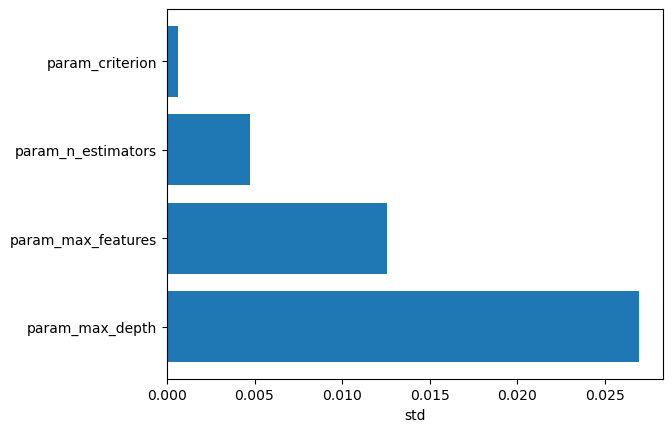

In [40]:
plot_variation_score(results)

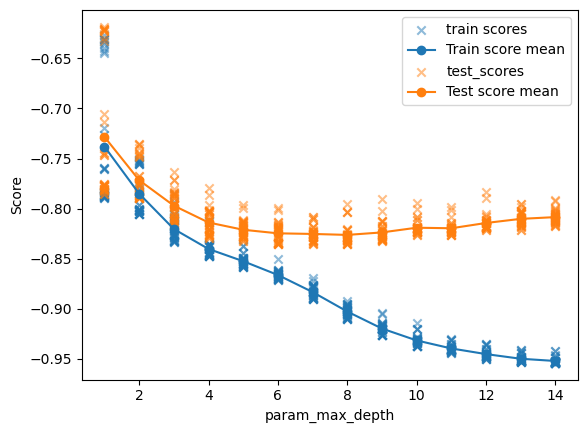

In [41]:
plot_train_validation_score_curve_all(results, 'param_max_depth')

The overfit starts on 6, so 6 seems a good choice

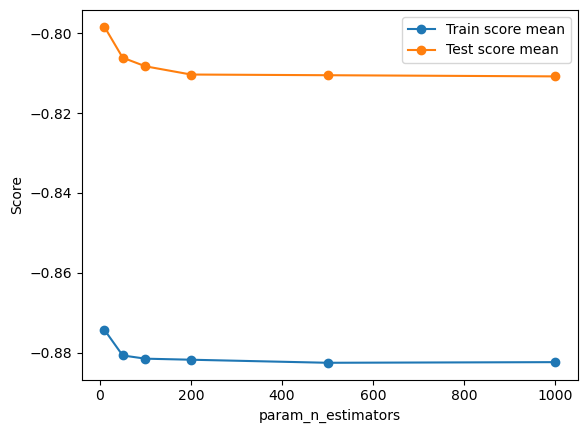

In [42]:
plot_train_validation_score_curve_all(results, 'param_n_estimators', show_tests=False)

Anything above 200 seems a good choice

<Axes: xlabel='param_max_features', ylabel='mean_test_score'>

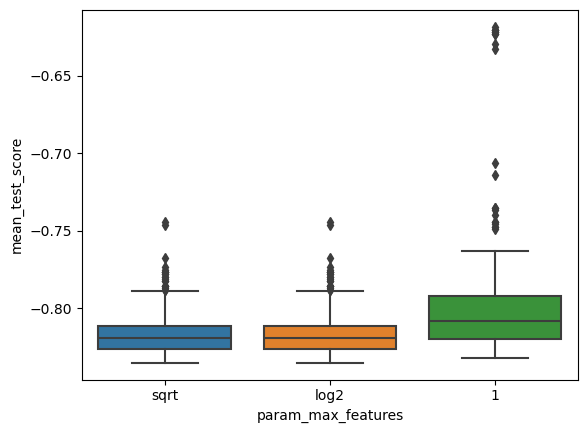

In [43]:
sns.boxplot(results, x='param_max_features', y='mean_test_score')

<Axes: xlabel='param_criterion', ylabel='mean_test_score'>

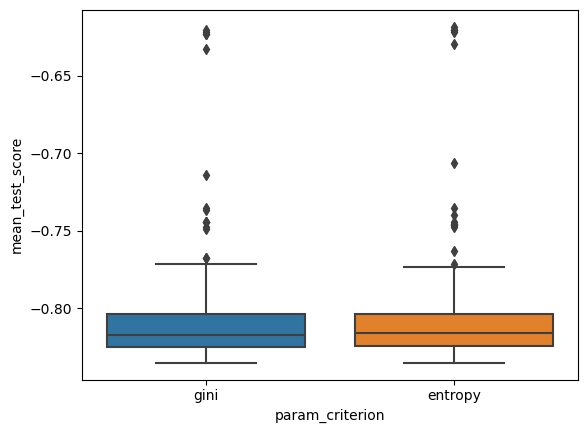

In [44]:
sns.boxplot(results, x='param_criterion', y='mean_test_score')

For this one, it's hard to know looking isolate, but sqrt gives better results on general.


In [45]:
final_model = RandomForestClassifier(max_depth=6, max_features='log2', n_estimators=200, random_state=rstate)
final_model.fit(X, y)

RandomForestClassifier(max_depth=6, max_features='log2', n_estimators=200,
                       random_state=7)

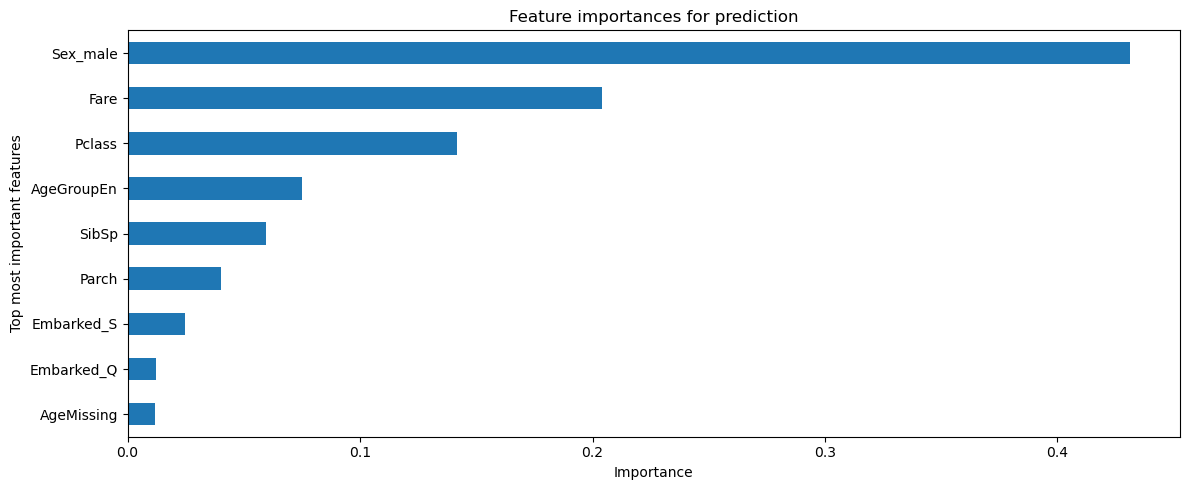

In [46]:
plot_feature_importances(final_model)
# higher values means more importance

As expected by the correlation analysis, the most important feature are the sex, followed by fare and PClass, two that relates with the financial condition, and AgeGroups in next.

Our model is learning interpretable insights from the data, we can imagine how it makes assumptions and predict the values.

## <a id='toc1_5_'></a>[Test data](#toc0_)

Process the test data for submission on Kaggle

In [47]:
test_data = pd.read_csv('data/titanic/test.csv', index_col="PassengerId")
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


Different from the train data, here we have missing value on Fare. It's only one value, so let's impute the mean and do the process done on the train data

In [48]:
# missing values, this can have a better treatment
test_data.loc[test_data['Fare'].isna(), 'Fare'] = test_data['Fare'].mean()
test_data = data_process(test_data)
test_data

,Pclass,SibSp,Parch,Fare,AgeMissing,AgeGroupEn,Sex_male,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,
892,3,0,0,7.8292,False,3,1,1,0
893,3,1,0,7.0000,False,3,0,0,1
894,2,0,0,9.6875,False,4,1,1,0
895,3,0,0,8.6625,False,2,1,0,1
896,3,1,1,12.2875,False,2,0,0,1
...,...,...,...,...,...,...,...,...,...
1305,3,0,0,8.0500,True,3,1,0,1
1306,1,0,0,108.9000,False,3,0,0,0
1307,3,0,0,7.2500,False,3,1,0,1


In [49]:
test_data_pred = final_model.predict(test_data)
test_data_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

### <a id='toc1_5_1_'></a>[Output for submission](#toc0_)

In [50]:
# formatting the output
test_output = pd.DataFrame(index=test_data.index)
test_output['Survived'] = test_data_pred
test_output

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,0
...,...
1305,0
1306,1
1307,0


In [51]:
test_output.to_csv('data/titanic/submission.csv')
print('Sucess saving output')

Sucess saving output


**FINAL SCORE: 0.78468**